In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')

In [3]:
model = 'nskewfcov'
matrix = load_matrix('data/Human_{model}_k9_matrix.csv.gz'.format(model=model))
N, k = matrix.shape

# Fast nearest neighbor routines by neighbor set membership

In [11]:
models = ['train', 'test', 'independent', 'ncov', 'nskewfcov']

In [13]:
proteome = 'Human'
kmers_dict = {}
for model in models:
    matrix = load_matrix('data/{proteome}_{model}_k9_matrix.csv.gz'.format(proteome=proteome, model=model))
    print(model, matrix.shape)
    kmers = matrix_to_kmers(matrix)
    kmers_dict[model] = kmers

train (5349026, 9)
test (5378304, 9)
independent (5349026, 9)
ncov (5349016, 9)
nskewfcov (5349016, 9)


In [29]:
distances = {}
for model in ['independent', 'ncov', 'nskewfcov']:
    kmers = kmers_dict[model]
    sample = set(np.random.choice(kmers, 5000))
    distance = distance_distribution(sample, set(kmers_dict['test']))
    distances[model] = distance

model = 'train'
matrix = load_matrix('data/Humannozf_{model}_k9_matrix.csv.gz'.format(model=model))
kmers = matrix_to_kmers(matrix)
sample = np.random.choice(kmers, 5000)
for s in sample:
    kmers.remove(s)
distance = distance_distribution(sample, set(kmers))
distance

In [16]:
proteome = 'Humanviruses'
model = 'test'
matrix = load_matrix('data/{proteome}_{model}_k9_matrix.csv.gz'.format(proteome=proteome,
                                                                       model=model))
print(model, matrix.shape)
kmers = matrix_to_kmers(matrix)

test (543879, 9)


In [27]:
sample = set(np.random.choice(kmers, 5000))
distance_virus = distance_distribution(sample, set(kmers_dict['test']))

In [32]:
distance_virus, distances['nskewfcov']

(array([   4,   73, 1807, 3110]), array([   0,   77, 1776, 3145]))

In [33]:
def nndist_probability(k, N):
    K = 20**k
    d = np.arange(0, k+1)
    Nc = lambda d: 19**d * falling_factorial(k, d+1)
    Ncs = Nc(d)
    cumulative = [0]
    cumulative.extend(1-np.exp(-np.cumsum(Ncs)*N/K))
    p = np.diff(cumulative)
    return d, p

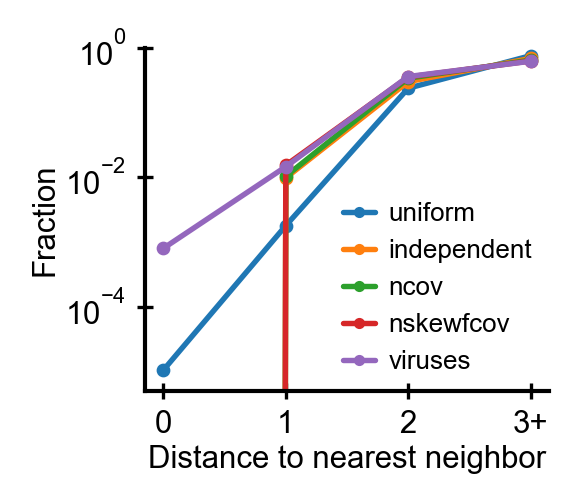

In [46]:
fig, ax = plt.subplots(figsize=(2.0, 1.75))
N = len(kmers_dict['test'])
d, p = nndist_probability(k, N)
ax.plot(d[:4], [p[0], p[1], p[2], np.sum(p[3:])], '-o', label='uniform')

for model, distance in distances.items():
    if model in ['nskew', 'test']:
        continue
    ax.plot(range(0, 4), distance/np.sum(distance), '-o', label=model)
ax.plot(range(0, 4), distance_virus/np.sum(distance_virus), '-o', label='viruses')

ax.set_ylim(5e-6, 1)
ax.set_xticks(range(0, 4))
ax.set_xticklabels(['0', '1', '2', '3+'])
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Fraction')
ax.set_xlabel('Distance to nearest neighbor')
fig.tight_layout()

In [71]:
for model, distance in distances.items():
    print(model, distance[1:]/np.sum(distance[1:]))

train [0.09868882 0.38664798 0.5146632 ]
independent [0.00830498 0.33289974 0.65879528]
ncov [0.01150921 0.35278223 0.63570857]
nskew [0.00323265 0.07061319 0.92615416]
nskewfcov [0.01841289 0.3658561  0.61573101]


# Model based only

In [86]:
proteome = 'Human'
model = 'nskewfcov'
matrix = load_matrix('data/{proteome}_{model}_k9_matrix.csv.gz'.format(proteome=proteome, model=model))
kmers_human = matrix_to_kmers(matrix)

In [87]:
proteome = 'Humanviruses'
model = 'nskewfcov'
matrix = load_matrix('data/{proteome}_{model}_k9_matrix.csv.gz'.format(proteome=proteome, model=model))
kmers_virus = matrix_to_kmers(matrix)

In [93]:
Nsample = 10000
kmers_human = np.array(kmers_human)
indices = np.random.randint(0, len(kmers_human), size=Nsample)
sample_human = kmers_human[indices]
reference = np.delete(kmers_human, indices)
reference = set(reference)

In [94]:
distance_human = distance_distribution(sample_human, reference)

In [95]:
sample_virus = np.random.choice(kmers_virus, Nsample, replace=False)
distance_virus = distance_distribution(sample_virus, reference)

In [112]:
sample_uniform = matrix_to_kmers(np.random.choice(np.arange(0, naminoacids, 1), size=(Nsample*10, 9)))
distance_uniform = distance_distribution(sample_uniform, reference)

In [113]:
distance_human, distance_virus, distance_uniform

(array([   9,  161, 3623, 6207]),
 array([   8,  156, 3302, 6534]),
 array([    0,   158, 11260, 88582]))

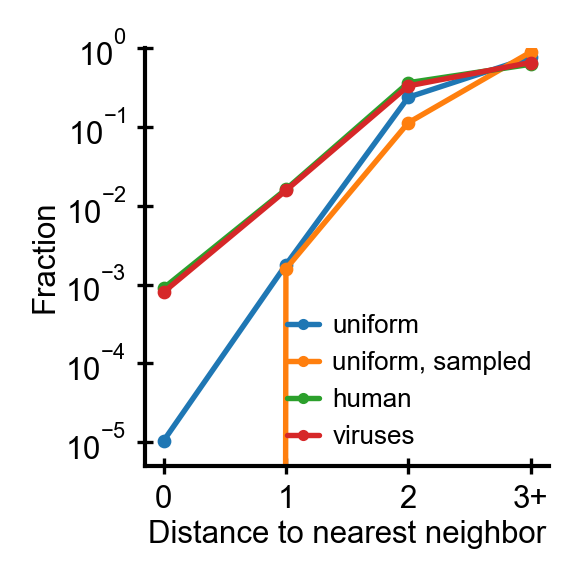

In [114]:
fig, ax = plt.subplots(figsize=(2.0, 2.0))
N = len(reference)
d, p = nndist_probability(k, N)
ax.plot(d[:4], [p[0], p[1], p[2], np.sum(p[3:])], '-o', label='uniform')
ax.plot(range(0, 4), distance_uniform/np.sum(distance_uniform), '-o', label='uniform, sampled')

ax.plot(range(0, 4), distance_human/np.sum(distance_human), '-o', label='human')
ax.plot(range(0, 4), distance_virus/np.sum(distance_virus), '-o', label='viruses')

ax.set_ylim(5e-6, 1)
ax.set_yscale('log')
ax.set_yticks(10.0**-np.arange(0, 6, 1))
ax.set_xticks(range(0, 4))
ax.set_xticklabels(['0', '1', '2', '3+'])
ax.legend()
ax.set_ylabel('Fraction')
ax.set_xlabel('Distance to nearest neighbor')
fig.tight_layout()

# Fast? nearest neighbor calculation using scikit learn routines

In [5]:
bt = BallTree(matrix[:500000, :], metric='hamming')

In [6]:
dists = (bt.query(matrix[500000:501000, :], return_distance=True)[0]*9).flatten()

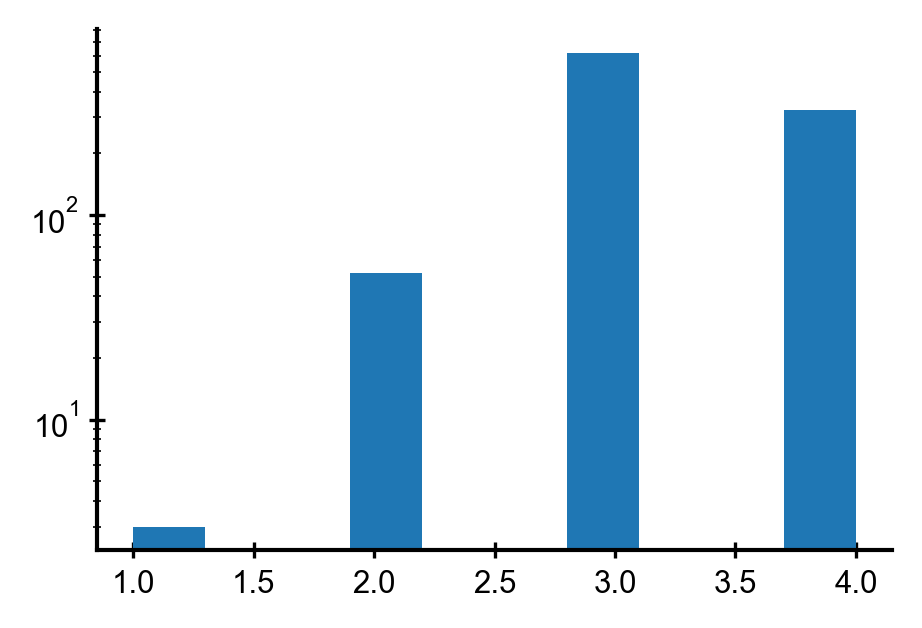

In [7]:
plt.hist(dists)
plt.yscale('log')

In [8]:
# use spotify annoy? https://github.com/spotify/annoy